In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1= pd.read_csv("../input/sunpharma-data-redefined/PreviousDayClose.csv", index_col= "Date", parse_dates= True)
df1

,Open,High,Low,Close,Adj Close,Volume,Growth% of Close from previous day
Date,,,,,,,
2009-12-01,145.354996,155.500000,145.354996,153.990005,144.129593,4338810.0,-2.772910
2009-12-02,156.399994,160.000000,148.660004,149.720001,140.133011,4689480.0,-0.163635
2009-12-03,150.014999,152.100006,148.750000,149.475006,139.903687,2534030.0,-0.806156
2009-12-04,148.500000,150.880005,145.110001,148.270004,138.775833,1216690.0,-2.077293
2009-12-07,148.509995,149.789993,144.110001,145.190002,135.893051,1559620.0,0.888487
...,...,...,...,...,...,...,...
2021-03-22,578.599976,593.599976,578.599976,591.000000,591.000000,7033955.0,-0.532999
2021-03-23,591.200012,594.700012,583.000000,587.849976,587.849976,5341729.0,-0.433782
2021-03-24,585.000000,597.000000,583.200012,585.299988,585.299988,7299582.0,-1.631640


<AxesSubplot:title={'center':'Sunpharma Closing price'}, xlabel='Date'>

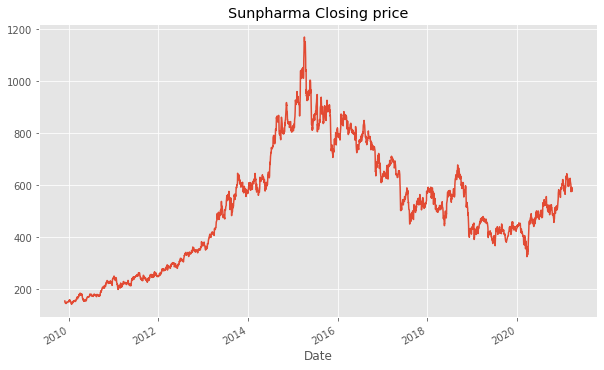

In [3]:
plt.style.use("ggplot")

df1["Close"].plot(label="Close", title="Sunpharma Closing price", figsize=(10,6))

## Data Preprocessing...  

In [4]:
# Features and Target segmentation
data = df1.iloc[:, 6:7].values # .values to convert it to numpy array

In [5]:
type(data)

numpy.ndarray

In [6]:
# Data Normalization

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler(feature_range= (0, 1))
ss = StandardScaler()

data_scaled = mm.fit_transform(data)
data_scaled

array([[0.47123328],
       [0.57132007],
       [0.5466742 ],
       ...,
       [0.51501022],
       [0.65388003],
       [0.64618673]])

In [7]:
# Keeping last 30 values(about a month) for testing
train_data = data_scaled[:2756, :]
test_data= data_scaled[2756:, :]

print(train_data.shape)
print(test_data.shape)

(2756, 1)
(30, 1)


In [8]:
# Creating a datastructure with 60 time stamps and 1 output(only on training set)

x_train= []
y_train= []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 0])
    
# Converting them to numpy arrays
x_train, y_train= np.array(x_train), np.array(y_train)

In [9]:
x_train. shape, y_train.shape

((2696, 60, 1), (2696,))

In [10]:
y_train= y_train.reshape(y_train.shape[0], 1)
y_train.shape

(2696, 1)

In [11]:
# Importing dependencies
import torch 
import torch.nn as nn
from torch.autograd import Variable 

In [12]:
X_train_tensors = Variable(torch.Tensor(x_train)).cuda()
# X_test_tensors = Variable(torch.Tensor(X_test)).cuda()

y_train_tensors = Variable(torch.Tensor(y_train)).cuda()
# y_test_tensors = Variable(torch.Tensor(y_test)) .cuda()

In [13]:
# Reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

# X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))


# Printing shapes 
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
# print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([2696, 1, 60]) torch.Size([2696, 1])


## Network Defination....

In [14]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes # number of classes
        self.num_layers = num_layers # number of layers
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # hidden state
        self.seq_length = seq_length # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 1
        self.fc = nn.Linear(128, num_classes) # fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() # internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state
        output = output.view(-1, self.hidden_size) # reshaping the output for fc layer
        out = self.relu(output)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

## Important parameters.... 

In [15]:
num_epochs = 250000 
learning_rate = 0.003 

input_size = 60 # number of features
hidden_size = 8 # number of features in hidden state
num_layers = 3 # number of stacked lstm layers

num_classes = 1 # number of output classes(coz regression)

In [16]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).cuda() #our lstm class

In [17]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

## Training Loop.... 

In [18]:
loss_min = np.Inf

for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    loss.backward() #calculates the loss of the loss function
 
    # save model if loss has decreased
    if loss.item() <= loss_min:
        print('Loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        loss_min,
        loss.item()))
        checkpoint = {'model': lstm1,
              'state_dict': lstm1.state_dict(),
              'optimizer' : optimizer.state_dict(),
              'train_loss': loss.item()}

        torch.save(checkpoint, 'checkpoint.pth')
        loss_min = loss.item()

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Loss decreased (inf --> 0.406420).  Saving model ...
Epoch: 0, loss: 0.40642
Loss decreased (0.406420 --> 0.346326).  Saving model ...
Loss decreased (0.346326 --> 0.291339).  Saving model ...
Loss decreased (0.291339 --> 0.241476).  Saving model ...
Loss decreased (0.241476 --> 0.196709).  Saving model ...
Loss decreased (0.196709 --> 0.156945).  Saving model ...
Loss decreased (0.156945 --> 0.122130).  Saving model ...
Loss decreased (0.122130 --> 0.092174).  Saving model ...
Loss decreased (0.092174 --> 0.066980).  Saving model ...
Loss decreased (0.066980 --> 0.046456).  Saving model ...
Loss decreased (0.046456 --> 0.030419).  Saving model ...
Loss decreased (0.030419 --> 0.018612).  Saving model ...
Loss decreased (0.018612 --> 0.010771).  Saving model ...
Loss decreased (0.010771 --> 0.006531).  Saving model ...
Loss decreased (0.006531 --> 0.005396).  Saving model ...
Loss decreased (0.005396 --> 0.005392).  Saving model ...
Loss decreased (0.005392 --> 0.005386).  Saving model

Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased

Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Epoch: 500, lo

Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased

Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Epoch: 800, loss: 0.00539
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Savin

Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005386).  Saving model ...
Loss decreased (0.005386 --> 0.005385).  Saving model ...
Loss decreased (0.005385 --> 0.005385).  Saving model ...
Loss decreased (0.005385 --> 0.005385).  Saving model ...
Loss decreased (0.005385 --> 0.005385).  Saving model ...
Loss decreased (0.005385 --> 0.005385).  Saving model ...
Loss decreased (0.005385 --> 0.005385).  Saving model ...
Loss decreased (0.005385 --> 0.005385).  Saving model ...
Loss decreased (0.005385 --> 0.005385).  Saving model ...
Loss decreased (0.005385 --> 0.005385).  Saving model ...
Loss decreased (0.005385 --> 0.005385).  Saving model ...
Loss decreased

Loss decreased (0.005380 --> 0.005380).  Saving model ...
Loss decreased (0.005380 --> 0.005380).  Saving model ...
Loss decreased (0.005380 --> 0.005380).  Saving model ...
Loss decreased (0.005380 --> 0.005380).  Saving model ...
Loss decreased (0.005380 --> 0.005380).  Saving model ...
Loss decreased (0.005380 --> 0.005380).  Saving model ...
Loss decreased (0.005380 --> 0.005379).  Saving model ...
Loss decreased (0.005379 --> 0.005379).  Saving model ...
Loss decreased (0.005379 --> 0.005379).  Saving model ...
Loss decreased (0.005379 --> 0.005379).  Saving model ...
Loss decreased (0.005379 --> 0.005379).  Saving model ...
Loss decreased (0.005379 --> 0.005379).  Saving model ...
Loss decreased (0.005379 --> 0.005379).  Saving model ...
Loss decreased (0.005379 --> 0.005379).  Saving model ...
Loss decreased (0.005379 --> 0.005378).  Saving model ...
Loss decreased (0.005378 --> 0.005378).  Saving model ...
Loss decreased (0.005378 --> 0.005378).  Saving model ...
Loss decreased

Loss decreased (0.005250 --> 0.005249).  Saving model ...
Loss decreased (0.005249 --> 0.005248).  Saving model ...
Loss decreased (0.005248 --> 0.005247).  Saving model ...
Loss decreased (0.005247 --> 0.005246).  Saving model ...
Loss decreased (0.005246 --> 0.005245).  Saving model ...
Loss decreased (0.005245 --> 0.005244).  Saving model ...
Loss decreased (0.005244 --> 0.005244).  Saving model ...
Loss decreased (0.005244 --> 0.005242).  Saving model ...
Loss decreased (0.005242 --> 0.005242).  Saving model ...
Loss decreased (0.005242 --> 0.005241).  Saving model ...
Loss decreased (0.005241 --> 0.005240).  Saving model ...
Loss decreased (0.005240 --> 0.005240).  Saving model ...
Loss decreased (0.005240 --> 0.005239).  Saving model ...
Loss decreased (0.005239 --> 0.005238).  Saving model ...
Loss decreased (0.005238 --> 0.005238).  Saving model ...
Loss decreased (0.005238 --> 0.005237).  Saving model ...
Loss decreased (0.005237 --> 0.005236).  Saving model ...
Loss decreased

Loss decreased (0.005205 --> 0.005205).  Saving model ...
Loss decreased (0.005205 --> 0.005205).  Saving model ...
Loss decreased (0.005205 --> 0.005205).  Saving model ...
Loss decreased (0.005205 --> 0.005204).  Saving model ...
Loss decreased (0.005204 --> 0.005204).  Saving model ...
Loss decreased (0.005204 --> 0.005204).  Saving model ...
Epoch: 1500, loss: 0.00520
Loss decreased (0.005204 --> 0.005203).  Saving model ...
Loss decreased (0.005203 --> 0.005203).  Saving model ...
Loss decreased (0.005203 --> 0.005203).  Saving model ...
Loss decreased (0.005203 --> 0.005203).  Saving model ...
Loss decreased (0.005203 --> 0.005203).  Saving model ...
Loss decreased (0.005203 --> 0.005203).  Saving model ...
Loss decreased (0.005203 --> 0.005203).  Saving model ...
Loss decreased (0.005203 --> 0.005203).  Saving model ...
Loss decreased (0.005203 --> 0.005202).  Saving model ...
Loss decreased (0.005202 --> 0.005202).  Saving model ...
Loss decreased (0.005202 --> 0.005202).  Savi

Loss decreased (0.005182 --> 0.005182).  Saving model ...
Loss decreased (0.005182 --> 0.005181).  Saving model ...
Loss decreased (0.005181 --> 0.005181).  Saving model ...
Loss decreased (0.005181 --> 0.005181).  Saving model ...
Loss decreased (0.005181 --> 0.005180).  Saving model ...
Loss decreased (0.005180 --> 0.005180).  Saving model ...
Loss decreased (0.005180 --> 0.005180).  Saving model ...
Loss decreased (0.005180 --> 0.005180).  Saving model ...
Loss decreased (0.005180 --> 0.005179).  Saving model ...
Loss decreased (0.005179 --> 0.005179).  Saving model ...
Epoch: 1800, loss: 0.00518
Loss decreased (0.005179 --> 0.005179).  Saving model ...
Loss decreased (0.005179 --> 0.005178).  Saving model ...
Loss decreased (0.005178 --> 0.005177).  Saving model ...
Loss decreased (0.005177 --> 0.005177).  Saving model ...
Loss decreased (0.005177 --> 0.005177).  Saving model ...
Loss decreased (0.005177 --> 0.005177).  Saving model ...
Loss decreased (0.005177 --> 0.005176).  Savi

Loss decreased (0.005078 --> 0.005077).  Saving model ...
Loss decreased (0.005077 --> 0.005077).  Saving model ...
Loss decreased (0.005077 --> 0.005076).  Saving model ...
Loss decreased (0.005076 --> 0.005075).  Saving model ...
Loss decreased (0.005075 --> 0.005075).  Saving model ...
Loss decreased (0.005075 --> 0.005074).  Saving model ...
Loss decreased (0.005074 --> 0.005074).  Saving model ...
Loss decreased (0.005074 --> 0.005073).  Saving model ...
Loss decreased (0.005073 --> 0.005073).  Saving model ...
Loss decreased (0.005073 --> 0.005072).  Saving model ...
Loss decreased (0.005072 --> 0.005072).  Saving model ...
Loss decreased (0.005072 --> 0.005071).  Saving model ...
Loss decreased (0.005071 --> 0.005071).  Saving model ...
Loss decreased (0.005071 --> 0.005070).  Saving model ...
Loss decreased (0.005070 --> 0.005069).  Saving model ...
Loss decreased (0.005069 --> 0.005069).  Saving model ...
Loss decreased (0.005069 --> 0.005068).  Saving model ...
Loss decreased

Loss decreased (0.004865 --> 0.004862).  Saving model ...
Epoch: 2300, loss: 0.00486
Loss decreased (0.004862 --> 0.004860).  Saving model ...
Loss decreased (0.004860 --> 0.004855).  Saving model ...
Loss decreased (0.004855 --> 0.004854).  Saving model ...
Loss decreased (0.004854 --> 0.004848).  Saving model ...
Loss decreased (0.004848 --> 0.004846).  Saving model ...
Loss decreased (0.004846 --> 0.004845).  Saving model ...
Loss decreased (0.004845 --> 0.004842).  Saving model ...
Loss decreased (0.004842 --> 0.004837).  Saving model ...
Loss decreased (0.004837 --> 0.004831).  Saving model ...
Loss decreased (0.004831 --> 0.004831).  Saving model ...
Loss decreased (0.004831 --> 0.004828).  Saving model ...
Loss decreased (0.004828 --> 0.004824).  Saving model ...
Loss decreased (0.004824 --> 0.004822).  Saving model ...
Loss decreased (0.004822 --> 0.004818).  Saving model ...
Loss decreased (0.004818 --> 0.004816).  Saving model ...
Loss decreased (0.004816 --> 0.004813).  Savi

Loss decreased (0.004452 --> 0.004447).  Saving model ...
Loss decreased (0.004447 --> 0.004445).  Saving model ...
Loss decreased (0.004445 --> 0.004444).  Saving model ...
Loss decreased (0.004444 --> 0.004439).  Saving model ...
Loss decreased (0.004439 --> 0.004437).  Saving model ...
Loss decreased (0.004437 --> 0.004431).  Saving model ...
Loss decreased (0.004431 --> 0.004430).  Saving model ...
Epoch: 3100, loss: 0.00443
Loss decreased (0.004430 --> 0.004429).  Saving model ...
Loss decreased (0.004429 --> 0.004425).  Saving model ...
Loss decreased (0.004425 --> 0.004424).  Saving model ...
Loss decreased (0.004424 --> 0.004414).  Saving model ...
Loss decreased (0.004414 --> 0.004405).  Saving model ...
Loss decreased (0.004405 --> 0.004401).  Saving model ...
Epoch: 3200, loss: 0.00454
Loss decreased (0.004401 --> 0.004392).  Saving model ...
Loss decreased (0.004392 --> 0.004383).  Saving model ...
Loss decreased (0.004383 --> 0.004382).  Saving model ...
Loss decreased (0.

Loss decreased (0.004056 --> 0.004055).  Saving model ...
Loss decreased (0.004055 --> 0.004054).  Saving model ...
Loss decreased (0.004054 --> 0.004053).  Saving model ...
Loss decreased (0.004053 --> 0.004053).  Saving model ...
Loss decreased (0.004053 --> 0.004052).  Saving model ...
Loss decreased (0.004052 --> 0.004052).  Saving model ...
Loss decreased (0.004052 --> 0.004048).  Saving model ...
Loss decreased (0.004048 --> 0.004047).  Saving model ...
Loss decreased (0.004047 --> 0.004041).  Saving model ...
Loss decreased (0.004041 --> 0.004040).  Saving model ...
Epoch: 4300, loss: 0.00406
Loss decreased (0.004040 --> 0.004037).  Saving model ...
Loss decreased (0.004037 --> 0.004033).  Saving model ...
Loss decreased (0.004033 --> 0.004029).  Saving model ...
Loss decreased (0.004029 --> 0.004027).  Saving model ...
Epoch: 4400, loss: 0.00413
Loss decreased (0.004027 --> 0.004023).  Saving model ...
Loss decreased (0.004023 --> 0.004014).  Saving model ...
Loss decreased (0.

Loss decreased (0.003790 --> 0.003790).  Saving model ...
Loss decreased (0.003790 --> 0.003788).  Saving model ...
Loss decreased (0.003788 --> 0.003788).  Saving model ...
Loss decreased (0.003788 --> 0.003783).  Saving model ...
Loss decreased (0.003783 --> 0.003783).  Saving model ...
Loss decreased (0.003783 --> 0.003781).  Saving model ...
Loss decreased (0.003781 --> 0.003779).  Saving model ...
Loss decreased (0.003779 --> 0.003779).  Saving model ...
Epoch: 5800, loss: 0.00383
Loss decreased (0.003779 --> 0.003778).  Saving model ...
Loss decreased (0.003778 --> 0.003777).  Saving model ...
Loss decreased (0.003777 --> 0.003777).  Saving model ...
Loss decreased (0.003777 --> 0.003775).  Saving model ...
Loss decreased (0.003775 --> 0.003773).  Saving model ...
Loss decreased (0.003773 --> 0.003772).  Saving model ...
Loss decreased (0.003772 --> 0.003770).  Saving model ...
Loss decreased (0.003770 --> 0.003768).  Saving model ...
Loss decreased (0.003768 --> 0.003767).  Savi

Loss decreased (0.003517 --> 0.003516).  Saving model ...
Loss decreased (0.003516 --> 0.003513).  Saving model ...
Loss decreased (0.003513 --> 0.003512).  Saving model ...
Loss decreased (0.003512 --> 0.003510).  Saving model ...
Loss decreased (0.003510 --> 0.003508).  Saving model ...
Epoch: 8700, loss: 0.00360
Epoch: 8800, loss: 0.00354
Loss decreased (0.003508 --> 0.003503).  Saving model ...
Loss decreased (0.003503 --> 0.003501).  Saving model ...
Epoch: 8900, loss: 0.00352
Loss decreased (0.003501 --> 0.003501).  Saving model ...
Loss decreased (0.003501 --> 0.003498).  Saving model ...
Loss decreased (0.003498 --> 0.003496).  Saving model ...
Epoch: 9000, loss: 0.00355
Loss decreased (0.003496 --> 0.003494).  Saving model ...
Loss decreased (0.003494 --> 0.003490).  Saving model ...
Loss decreased (0.003490 --> 0.003488).  Saving model ...
Loss decreased (0.003488 --> 0.003487).  Saving model ...
Loss decreased (0.003487 --> 0.003487).  Saving model ...
Loss decreased (0.0034

Loss decreased (0.003324 --> 0.003323).  Saving model ...
Loss decreased (0.003323 --> 0.003323).  Saving model ...
Loss decreased (0.003323 --> 0.003322).  Saving model ...
Loss decreased (0.003322 --> 0.003322).  Saving model ...
Loss decreased (0.003322 --> 0.003321).  Saving model ...
Epoch: 12000, loss: 0.00342
Loss decreased (0.003321 --> 0.003320).  Saving model ...
Epoch: 12100, loss: 0.00333
Loss decreased (0.003320 --> 0.003316).  Saving model ...
Loss decreased (0.003316 --> 0.003311).  Saving model ...
Loss decreased (0.003311 --> 0.003308).  Saving model ...
Loss decreased (0.003308 --> 0.003308).  Saving model ...
Loss decreased (0.003308 --> 0.003306).  Saving model ...
Epoch: 12200, loss: 0.00343
Loss decreased (0.003306 --> 0.003304).  Saving model ...
Loss decreased (0.003304 --> 0.003304).  Saving model ...
Loss decreased (0.003304 --> 0.003303).  Saving model ...
Loss decreased (0.003303 --> 0.003302).  Saving model ...
Epoch: 12300, loss: 0.00330
Loss decreased (0.

Epoch: 15300, loss: 0.00318
Loss decreased (0.003096 --> 0.003093).  Saving model ...
Epoch: 15400, loss: 0.00311
Loss decreased (0.003093 --> 0.003092).  Saving model ...
Loss decreased (0.003092 --> 0.003091).  Saving model ...
Loss decreased (0.003091 --> 0.003087).  Saving model ...
Loss decreased (0.003087 --> 0.003086).  Saving model ...
Loss decreased (0.003086 --> 0.003083).  Saving model ...
Loss decreased (0.003083 --> 0.003079).  Saving model ...
Epoch: 15500, loss: 0.00309
Loss decreased (0.003079 --> 0.003077).  Saving model ...
Epoch: 15600, loss: 0.00314
Loss decreased (0.003077 --> 0.003076).  Saving model ...
Loss decreased (0.003076 --> 0.003070).  Saving model ...
Loss decreased (0.003070 --> 0.003069).  Saving model ...
Loss decreased (0.003069 --> 0.003066).  Saving model ...
Epoch: 15700, loss: 0.00308
Loss decreased (0.003066 --> 0.003062).  Saving model ...
Loss decreased (0.003062 --> 0.003059).  Saving model ...
Epoch: 15800, loss: 0.00311
Loss decreased (0.00

Loss decreased (0.002789 --> 0.002787).  Saving model ...
Epoch: 19900, loss: 0.00292
Loss decreased (0.002787 --> 0.002783).  Saving model ...
Loss decreased (0.002783 --> 0.002776).  Saving model ...
Loss decreased (0.002776 --> 0.002776).  Saving model ...
Epoch: 20000, loss: 0.00279
Loss decreased (0.002776 --> 0.002775).  Saving model ...
Loss decreased (0.002775 --> 0.002769).  Saving model ...
Loss decreased (0.002769 --> 0.002766).  Saving model ...
Epoch: 20100, loss: 0.00287
Loss decreased (0.002766 --> 0.002761).  Saving model ...
Loss decreased (0.002761 --> 0.002761).  Saving model ...
Loss decreased (0.002761 --> 0.002761).  Saving model ...
Epoch: 20200, loss: 0.00296
Loss decreased (0.002761 --> 0.002759).  Saving model ...
Loss decreased (0.002759 --> 0.002754).  Saving model ...
Epoch: 20300, loss: 0.00289
Loss decreased (0.002754 --> 0.002750).  Saving model ...
Loss decreased (0.002750 --> 0.002749).  Saving model ...
Epoch: 20400, loss: 0.00277
Loss decreased (0.00

Loss decreased (0.002496 --> 0.002489).  Saving model ...
Epoch: 25300, loss: 0.00255
Epoch: 25400, loss: 0.00274
Loss decreased (0.002489 --> 0.002487).  Saving model ...
Epoch: 25500, loss: 0.00255
Loss decreased (0.002487 --> 0.002486).  Saving model ...
Loss decreased (0.002486 --> 0.002480).  Saving model ...
Loss decreased (0.002480 --> 0.002475).  Saving model ...
Epoch: 25600, loss: 0.00251
Loss decreased (0.002475 --> 0.002474).  Saving model ...
Epoch: 25700, loss: 0.00260
Loss decreased (0.002474 --> 0.002474).  Saving model ...
Loss decreased (0.002474 --> 0.002473).  Saving model ...
Loss decreased (0.002473 --> 0.002466).  Saving model ...
Loss decreased (0.002466 --> 0.002464).  Saving model ...
Epoch: 25800, loss: 0.00249
Epoch: 25900, loss: 0.00259
Loss decreased (0.002464 --> 0.002459).  Saving model ...
Epoch: 26000, loss: 0.00248
Epoch: 26100, loss: 0.00249
Loss decreased (0.002459 --> 0.002456).  Saving model ...
Loss decreased (0.002456 --> 0.002456).  Saving mode

Epoch: 34500, loss: 0.00222
Loss decreased (0.002203 --> 0.002201).  Saving model ...
Epoch: 34600, loss: 0.00226
Loss decreased (0.002201 --> 0.002193).  Saving model ...
Loss decreased (0.002193 --> 0.002193).  Saving model ...
Loss decreased (0.002193 --> 0.002193).  Saving model ...
Loss decreased (0.002193 --> 0.002190).  Saving model ...
Epoch: 34700, loss: 0.00224
Epoch: 34800, loss: 0.00230
Epoch: 34900, loss: 0.00250
Epoch: 35000, loss: 0.00241
Epoch: 35100, loss: 0.00226
Loss decreased (0.002190 --> 0.002188).  Saving model ...
Loss decreased (0.002188 --> 0.002185).  Saving model ...
Loss decreased (0.002185 --> 0.002179).  Saving model ...
Epoch: 35200, loss: 0.00224
Epoch: 35300, loss: 0.00231
Epoch: 35400, loss: 0.00231
Loss decreased (0.002179 --> 0.002175).  Saving model ...
Epoch: 35500, loss: 0.00223
Epoch: 35600, loss: 0.00236
Loss decreased (0.002175 --> 0.002173).  Saving model ...
Loss decreased (0.002173 --> 0.002165).  Saving model ...
Loss decreased (0.002165 -

Epoch: 46500, loss: 0.00206
Epoch: 46600, loss: 0.00205
Loss decreased (0.001942 --> 0.001942).  Saving model ...
Epoch: 46700, loss: 0.00200
Loss decreased (0.001942 --> 0.001940).  Saving model ...
Loss decreased (0.001940 --> 0.001935).  Saving model ...
Epoch: 46800, loss: 0.00222
Epoch: 46900, loss: 0.00208
Epoch: 47000, loss: 0.00215
Epoch: 47100, loss: 0.00203
Loss decreased (0.001935 --> 0.001934).  Saving model ...
Loss decreased (0.001934 --> 0.001929).  Saving model ...
Epoch: 47200, loss: 0.00209
Epoch: 47300, loss: 0.00204
Loss decreased (0.001929 --> 0.001926).  Saving model ...
Epoch: 47400, loss: 0.00220
Loss decreased (0.001926 --> 0.001926).  Saving model ...
Loss decreased (0.001926 --> 0.001925).  Saving model ...
Epoch: 47500, loss: 0.00201
Loss decreased (0.001925 --> 0.001919).  Saving model ...
Epoch: 47600, loss: 0.00197
Epoch: 47700, loss: 0.00208
Loss decreased (0.001919 --> 0.001918).  Saving model ...
Epoch: 47800, loss: 0.00200
Loss decreased (0.001918 -->

Epoch: 59500, loss: 0.00183
Epoch: 59600, loss: 0.00206
Epoch: 59700, loss: 0.00196
Loss decreased (0.001719 --> 0.001717).  Saving model ...
Loss decreased (0.001717 --> 0.001717).  Saving model ...
Epoch: 59800, loss: 0.00177
Loss decreased (0.001717 --> 0.001714).  Saving model ...
Loss decreased (0.001714 --> 0.001714).  Saving model ...
Epoch: 59900, loss: 0.00199
Loss decreased (0.001714 --> 0.001710).  Saving model ...
Epoch: 60000, loss: 0.00197
Epoch: 60100, loss: 0.00172
Epoch: 60200, loss: 0.00177
Loss decreased (0.001710 --> 0.001704).  Saving model ...
Epoch: 60300, loss: 0.00176
Loss decreased (0.001704 --> 0.001703).  Saving model ...
Loss decreased (0.001703 --> 0.001702).  Saving model ...
Loss decreased (0.001702 --> 0.001697).  Saving model ...
Epoch: 60400, loss: 0.00199
Epoch: 60500, loss: 0.00193
Loss decreased (0.001697 --> 0.001696).  Saving model ...
Epoch: 60600, loss: 0.00186
Epoch: 60700, loss: 0.00188
Loss decreased (0.001696 --> 0.001693).  Saving model ..

Epoch: 74200, loss: 0.00156
Epoch: 74300, loss: 0.00175
Loss decreased (0.001541 --> 0.001537).  Saving model ...
Epoch: 74400, loss: 0.00164
Epoch: 74500, loss: 0.00160
Epoch: 74600, loss: 0.00154
Loss decreased (0.001537 --> 0.001536).  Saving model ...
Epoch: 74700, loss: 0.00161
Loss decreased (0.001536 --> 0.001535).  Saving model ...
Epoch: 74800, loss: 0.00185
Epoch: 74900, loss: 0.00175
Epoch: 75000, loss: 0.00157
Loss decreased (0.001535 --> 0.001534).  Saving model ...
Epoch: 75100, loss: 0.00154
Epoch: 75200, loss: 0.00162
Loss decreased (0.001534 --> 0.001531).  Saving model ...
Epoch: 75300, loss: 0.00180
Epoch: 75400, loss: 0.00159
Epoch: 75500, loss: 0.00172
Epoch: 75600, loss: 0.00218
Loss decreased (0.001531 --> 0.001530).  Saving model ...
Loss decreased (0.001530 --> 0.001529).  Saving model ...
Epoch: 75700, loss: 0.00174
Epoch: 75800, loss: 0.00155
Epoch: 75900, loss: 0.00155
Loss decreased (0.001529 --> 0.001528).  Saving model ...
Loss decreased (0.001528 --> 0.0

Epoch: 90900, loss: 0.00157
Epoch: 91000, loss: 0.00145
Epoch: 91100, loss: 0.00197
Epoch: 91200, loss: 0.00156
Loss decreased (0.001393 --> 0.001393).  Saving model ...
Loss decreased (0.001393 --> 0.001392).  Saving model ...
Epoch: 91300, loss: 0.00140
Epoch: 91400, loss: 0.00180
Epoch: 91500, loss: 0.00177
Epoch: 91600, loss: 0.00145
Loss decreased (0.001392 --> 0.001391).  Saving model ...
Epoch: 91700, loss: 0.00149
Loss decreased (0.001391 --> 0.001388).  Saving model ...
Epoch: 91800, loss: 0.00150
Loss decreased (0.001388 --> 0.001386).  Saving model ...
Epoch: 91900, loss: 0.00161
Loss decreased (0.001386 --> 0.001386).  Saving model ...
Epoch: 92000, loss: 0.00167
Epoch: 92100, loss: 0.00143
Loss decreased (0.001386 --> 0.001382).  Saving model ...
Epoch: 92200, loss: 0.00177
Epoch: 92300, loss: 0.00142
Epoch: 92400, loss: 0.00170
Epoch: 92500, loss: 0.00154
Epoch: 92600, loss: 0.00148
Epoch: 92700, loss: 0.00155
Loss decreased (0.001382 --> 0.001375).  Saving model ...
Loss

Epoch: 108700, loss: 0.00131
Epoch: 108800, loss: 0.00143
Epoch: 108900, loss: 0.00154
Loss decreased (0.001275 --> 0.001272).  Saving model ...
Epoch: 109000, loss: 0.00128
Epoch: 109100, loss: 0.00137
Loss decreased (0.001272 --> 0.001272).  Saving model ...
Loss decreased (0.001272 --> 0.001270).  Saving model ...
Epoch: 109200, loss: 0.00147
Epoch: 109300, loss: 0.00145
Epoch: 109400, loss: 0.00164
Loss decreased (0.001270 --> 0.001269).  Saving model ...
Epoch: 109500, loss: 0.00130
Loss decreased (0.001269 --> 0.001267).  Saving model ...
Epoch: 109600, loss: 0.00166
Epoch: 109700, loss: 0.00151
Epoch: 109800, loss: 0.00145
Epoch: 109900, loss: 0.00132
Epoch: 110000, loss: 0.00248
Epoch: 110100, loss: 0.00155
Epoch: 110200, loss: 0.00150
Epoch: 110300, loss: 0.00141
Epoch: 110400, loss: 0.00151
Epoch: 110500, loss: 0.00127
Epoch: 110600, loss: 0.00134
Epoch: 110700, loss: 0.00140
Loss decreased (0.001267 --> 0.001264).  Saving model ...
Epoch: 110800, loss: 0.00132
Epoch: 110900,

Epoch: 128200, loss: 0.00137
Epoch: 128300, loss: 0.00133
Epoch: 128400, loss: 0.00169
Epoch: 128500, loss: 0.00148
Epoch: 128600, loss: 0.00129
Epoch: 128700, loss: 0.00123
Loss decreased (0.001182 --> 0.001181).  Saving model ...
Epoch: 128800, loss: 0.00151
Loss decreased (0.001181 --> 0.001176).  Saving model ...
Loss decreased (0.001176 --> 0.001175).  Saving model ...
Epoch: 128900, loss: 0.00133
Epoch: 129000, loss: 0.00132
Epoch: 129100, loss: 0.00141
Epoch: 129200, loss: 0.00132
Epoch: 129300, loss: 0.00126
Epoch: 129400, loss: 0.00140
Epoch: 129500, loss: 0.00132
Loss decreased (0.001175 --> 0.001174).  Saving model ...
Epoch: 129600, loss: 0.00120
Epoch: 129700, loss: 0.00169
Epoch: 129800, loss: 0.00137
Epoch: 129900, loss: 0.00136
Epoch: 130000, loss: 0.00134
Epoch: 130100, loss: 0.00153
Epoch: 130200, loss: 0.00143
Loss decreased (0.001174 --> 0.001171).  Saving model ...
Epoch: 130300, loss: 0.00149
Loss decreased (0.001171 --> 0.001171).  Saving model ...
Loss decreased

Epoch: 147500, loss: 0.00141
Loss decreased (0.001106 --> 0.001105).  Saving model ...
Loss decreased (0.001105 --> 0.001103).  Saving model ...
Loss decreased (0.001103 --> 0.001099).  Saving model ...
Epoch: 147600, loss: 0.00133
Epoch: 147700, loss: 0.00147
Epoch: 147800, loss: 0.00112
Epoch: 147900, loss: 0.00149
Epoch: 148000, loss: 0.00133
Epoch: 148100, loss: 0.00114
Epoch: 148200, loss: 0.00127
Epoch: 148300, loss: 0.00135
Epoch: 148400, loss: 0.00118
Epoch: 148500, loss: 0.00133
Epoch: 148600, loss: 0.00133
Epoch: 148700, loss: 0.00135
Epoch: 148800, loss: 0.00120
Epoch: 148900, loss: 0.00144
Epoch: 149000, loss: 0.00143
Loss decreased (0.001099 --> 0.001095).  Saving model ...
Epoch: 149100, loss: 0.00140
Epoch: 149200, loss: 0.00139
Epoch: 149300, loss: 0.00133
Epoch: 149400, loss: 0.00120
Epoch: 149500, loss: 0.00137
Epoch: 149600, loss: 0.00111
Epoch: 149700, loss: 0.00112
Epoch: 149800, loss: 0.00119
Loss decreased (0.001095 --> 0.001094).  Saving model ...
Epoch: 149900,

Loss decreased (0.001033 --> 0.001033).  Saving model ...
Epoch: 168000, loss: 0.00125
Epoch: 168100, loss: 0.00105
Epoch: 168200, loss: 0.00121
Epoch: 168300, loss: 0.00107
Epoch: 168400, loss: 0.00122
Epoch: 168500, loss: 0.00116
Loss decreased (0.001033 --> 0.001033).  Saving model ...
Epoch: 168600, loss: 0.00141
Epoch: 168700, loss: 0.00114
Epoch: 168800, loss: 0.00134
Epoch: 168900, loss: 0.00126
Epoch: 169000, loss: 0.00118
Loss decreased (0.001033 --> 0.001033).  Saving model ...
Epoch: 169100, loss: 0.00103
Loss decreased (0.001033 --> 0.001032).  Saving model ...
Epoch: 169200, loss: 0.00113
Epoch: 169300, loss: 0.00119
Epoch: 169400, loss: 0.00114
Epoch: 169500, loss: 0.00120
Epoch: 169600, loss: 0.00104
Epoch: 169700, loss: 0.00134
Epoch: 169800, loss: 0.00116
Loss decreased (0.001032 --> 0.001029).  Saving model ...
Epoch: 169900, loss: 0.00118
Epoch: 170000, loss: 0.00124
Loss decreased (0.001029 --> 0.001025).  Saving model ...
Epoch: 170100, loss: 0.00138
Epoch: 170200,

Epoch: 188500, loss: 0.00138
Epoch: 188600, loss: 0.00124
Epoch: 188700, loss: 0.00108
Epoch: 188800, loss: 0.00106
Epoch: 188900, loss: 0.00125
Epoch: 189000, loss: 0.00146
Epoch: 189100, loss: 0.00136
Epoch: 189200, loss: 0.00117
Epoch: 189300, loss: 0.00132
Epoch: 189400, loss: 0.00110
Epoch: 189500, loss: 0.00138
Epoch: 189600, loss: 0.00122
Epoch: 189700, loss: 0.00115
Epoch: 189800, loss: 0.00104
Epoch: 189900, loss: 0.00098
Loss decreased (0.000968 --> 0.000963).  Saving model ...
Epoch: 190000, loss: 0.00111
Epoch: 190100, loss: 0.00109
Epoch: 190200, loss: 0.00113
Epoch: 190300, loss: 0.00104
Epoch: 190400, loss: 0.00112
Epoch: 190500, loss: 0.00108
Epoch: 190600, loss: 0.00118
Epoch: 190700, loss: 0.00118
Epoch: 190800, loss: 0.00100
Epoch: 190900, loss: 0.00139
Epoch: 191000, loss: 0.00125
Loss decreased (0.000963 --> 0.000961).  Saving model ...
Epoch: 191100, loss: 0.00120
Epoch: 191200, loss: 0.00119
Epoch: 191300, loss: 0.00110
Epoch: 191400, loss: 0.00113
Epoch: 191500,

Epoch: 210200, loss: 0.00143
Epoch: 210300, loss: 0.00117
Epoch: 210400, loss: 0.00124
Epoch: 210500, loss: 0.00113
Epoch: 210600, loss: 0.00105
Epoch: 210700, loss: 0.00092
Epoch: 210800, loss: 0.00100
Epoch: 210900, loss: 0.00125
Epoch: 211000, loss: 0.00096
Loss decreased (0.000909 --> 0.000908).  Saving model ...
Epoch: 211100, loss: 0.00098
Loss decreased (0.000908 --> 0.000907).  Saving model ...
Epoch: 211200, loss: 0.00096
Epoch: 211300, loss: 0.00098
Epoch: 211400, loss: 0.00113
Epoch: 211500, loss: 0.00105
Epoch: 211600, loss: 0.00127
Epoch: 211700, loss: 0.00106
Loss decreased (0.000907 --> 0.000905).  Saving model ...
Epoch: 211800, loss: 0.00103
Epoch: 211900, loss: 0.00095
Epoch: 212000, loss: 0.00107
Epoch: 212100, loss: 0.00111
Epoch: 212200, loss: 0.00119
Epoch: 212300, loss: 0.00134
Loss decreased (0.000905 --> 0.000905).  Saving model ...
Epoch: 212400, loss: 0.00110
Epoch: 212500, loss: 0.00103
Epoch: 212600, loss: 0.00093
Epoch: 212700, loss: 0.00102
Epoch: 212800,

Epoch: 232100, loss: 0.00096
Epoch: 232200, loss: 0.00098
Epoch: 232300, loss: 0.00136
Epoch: 232400, loss: 0.00090
Epoch: 232500, loss: 0.00107
Epoch: 232600, loss: 0.00121
Epoch: 232700, loss: 0.00108
Epoch: 232800, loss: 0.00108
Epoch: 232900, loss: 0.00108
Epoch: 233000, loss: 0.00102
Epoch: 233100, loss: 0.00087
Epoch: 233200, loss: 0.00119
Epoch: 233300, loss: 0.00093
Epoch: 233400, loss: 0.00105
Epoch: 233500, loss: 0.00095
Epoch: 233600, loss: 0.00109
Epoch: 233700, loss: 0.00115
Epoch: 233800, loss: 0.00090
Loss decreased (0.000849 --> 0.000848).  Saving model ...
Loss decreased (0.000848 --> 0.000845).  Saving model ...
Epoch: 233900, loss: 0.00126
Epoch: 234000, loss: 0.00091
Epoch: 234100, loss: 0.00114
Epoch: 234200, loss: 0.00087
Epoch: 234300, loss: 0.00172
Epoch: 234400, loss: 0.00130
Epoch: 234500, loss: 0.00089
Epoch: 234600, loss: 0.00091
Epoch: 234700, loss: 0.00101
Epoch: 234800, loss: 0.00126
Epoch: 234900, loss: 0.00099
Epoch: 235000, loss: 0.00113
Epoch: 235100,

## Loading model with minimum loss 

In [19]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    train_loss= checkpoint['train_loss']
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model, train_loss

In [20]:
model_best, train_loss = load_checkpoint('checkpoint.pth')
model_best= model_best
train_loss= train_loss
print(model_best)

LSTM1(
  (lstm): LSTM(60, 8, num_layers=3, batch_first=True)
  (fc_1): Linear(in_features=8, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


## Testing the model... 

In [21]:
# Creating a datastructure with 60 time stamps and 1 output(for entire data, previously done just on training set)

x= []
y= []

for i in range(60, len(data_scaled)):
    x.append(data_scaled[i-60:i, :])
    y.append(data_scaled[i, 0])
    
# Converting them to numpy arrays
x, y= np.array(x), np.array(y)

In [22]:
X_tensors = Variable(torch.Tensor(x)).cuda()
# X_test_tensors = Variable(torch.Tensor(X_test)).cuda()

y_tensors = Variable(torch.Tensor(y)).cuda()
# y_test_tensors = Variable(torch.Tensor(y_test)) .cuda()


X_tensors_final = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))

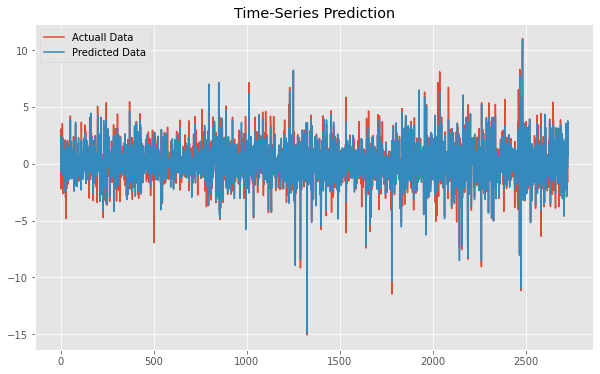

In [23]:
# On complete dataset

train_predict = model_best(X_tensors_final.cuda())#forward pass

data_predict = train_predict.data.cpu()
data_predict = data_predict.numpy() #numpy conversion

dataY_plot = y_tensors.data.cpu()
dataY_plot = dataY_plot.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot.reshape(-1, 1))
plt.figure(figsize=(10,6)) #plotting

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

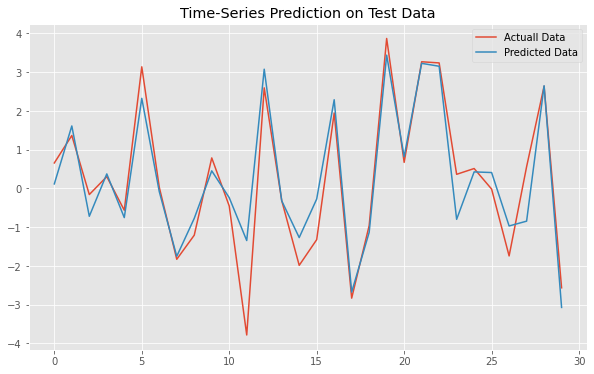

In [24]:
# Only on Test set
# We droped the last 30 values for testing above(during data preprocessing)

X_test= X_train_tensors_final[-30:, :].cuda()
y_test= y_train_tensors[-30:, :].cuda()


test_predict= model_best(X_test) # Forward pass

predicted= test_predict.data.cpu()
predicted= predicted.numpy()

real_test= y_test.data.cpu()
real_test= real_test.numpy()


predicted= mm.inverse_transform(predicted)
real_test= mm.inverse_transform(real_test)

plt.figure(figsize=(10,6)) #plotting
plt.plot(real_test, label='Actuall Data') #actual plot
plt.plot(predicted, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction on Test Data')
plt.legend()
plt.show() 

## R2 score calculation over Test set...

In [25]:
from sklearn.metrics import r2_score
coefficient_of_dermination = r2_score(real_test, predicted)
print(coefficient_of_dermination)

0.8706176947916204


## Saving the model... 

In [26]:
# Saving the LSTM model
import joblib
joblib.dump(model_best, '1DayGrowth%Approch2.pkl')

['1DayGrowth%Approch2.pkl']